In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


In [ ]:
! pip install matplotlib seaborn scikit-learn

In [ ]:
import pandas as pd
import torch
import clip
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/amazon_reviews_text_deduplicated.csv")

print("Dataset size:", len(df))
df.head()


Dataset size: 16074


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5.0,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5.0,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4.0,Great phone to replace my lost phone. The only...,0.0


In [ ]:
len(df)

16074

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["cleaned_review"] = df["Reviews"].apply(clean_text)
df[["Reviews", "cleaned_review"]].head()


,Reviews,cleaned_review
0,I feel so LUCKY to have found this used (phone...,i feel so lucky to have found this used phone ...
1,"nice phone, nice up grade from my pantach revu...",nice phone nice up grade from my pantach revue...
2,Very pleased,very pleased
3,It works good but it goes slow sometimes but i...,it works good but it goes slow sometimes but i...
4,Great phone to replace my lost phone. The only...,great phone to replace my lost phone the only ...


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()


In [ ]:
sentiment_prompts = [
    "This review expresses a very positive opinion",
    "This review expresses a neutral opinion",
    "This review expresses a very negative opinion"
]

sentiment_labels = ["Positive", "Neutral", "Negative"]


In [ ]:
with torch.no_grad():
    prompt_tokens = clip.tokenize(sentiment_prompts).to(device)
    prompt_embeddings = model.encode_text(prompt_tokens)
    prompt_embeddings = prompt_embeddings / prompt_embeddings.norm(dim=-1, keepdim=True)


In [ ]:
def encode_texts(text_list, batch_size=64):
    all_embeddings = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]

        tokens = clip.tokenize(
            batch,
            truncate=True
        ).to(device)

        with torch.no_grad():
            embeddings = model.encode_text(tokens)
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)

        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


In [ ]:
review_embeddings = encode_texts(df["cleaned_review"].tolist())
print("Review embeddings shape:", review_embeddings.shape)


Review embeddings shape: (16074, 512)


In [ ]:
similarity_scores = cosine_similarity(
    review_embeddings,
    prompt_embeddings.cpu().numpy()
)

In [ ]:
predicted_indices = similarity_scores.argmax(axis=1)
df["predicted_sentiment"] = [sentiment_labels[i] for i in predicted_indices]

df[["cleaned_review", "predicted_sentiment"]].head()


,cleaned_review,predicted_sentiment
0,i feel so lucky to have found this used phone ...,Neutral
1,nice phone nice up grade from my pantach revue...,Neutral
2,very pleased,Positive
3,it works good but it goes slow sometimes but i...,Negative
4,great phone to replace my lost phone the only ...,Negative


In [ ]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"

df["rating_sentiment"] = df["Rating"].apply(rating_to_sentiment)


In [ ]:
df["sentiment_mismatch"] = df["predicted_sentiment"] != df["rating_sentiment"]

df[["Rating", "predicted_sentiment", "rating_sentiment", "sentiment_mismatch"]].head()


,Rating,predicted_sentiment,rating_sentiment,sentiment_mismatch
0,5.0,Neutral,Positive,True
1,4.0,Neutral,Positive,True
2,5.0,Positive,Positive,False
3,4.0,Negative,Positive,True
4,4.0,Negative,Positive,True


In [ ]:
print("Mismatch count:")
print(df["sentiment_mismatch"].value_counts())

print("\nSentiment distribution:")
print(df["predicted_sentiment"].value_counts())


Mismatch count:
sentiment_mismatch
True     10677
False     5397
Name: count, dtype: int64

Sentiment distribution:
predicted_sentiment
Negative    7315
Neutral     6120
Positive    2639
Name: count, dtype: int64


In [ ]:
df.to_csv("final_review_sentiment_analysis.csv", index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


In [ ]:
required_cols = [
    "Rating",
    "predicted_sentiment",
    "rating_sentiment",
    "sentiment_mismatch"
]

df[required_cols].head()


,Rating,predicted_sentiment,rating_sentiment,sentiment_mismatch
0,5.0,Neutral,Positive,True
1,4.0,Neutral,Positive,True
2,5.0,Positive,Positive,False
3,4.0,Negative,Positive,True
4,4.0,Negative,Positive,True


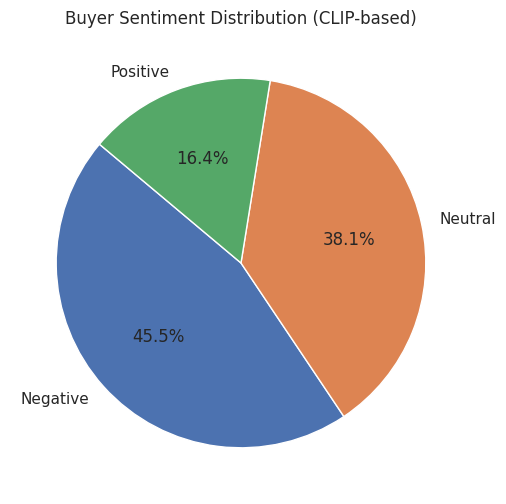

In [ ]:
sentiment_counts = df["predicted_sentiment"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Buyer Sentiment Distribution (CLIP-based)")
plt.show()


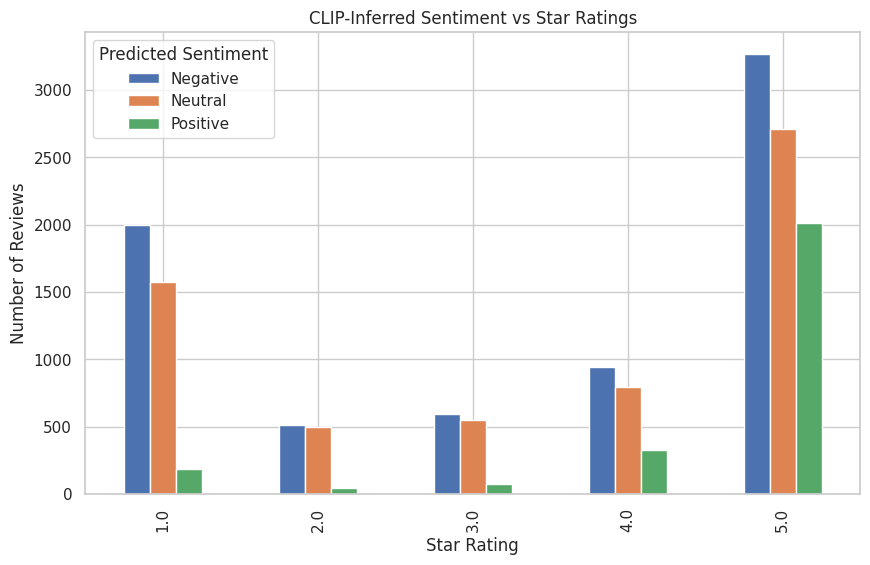

In [ ]:
rating_sentiment_counts = (
    df.groupby(["Rating", "predicted_sentiment"])
      .size()
      .unstack(fill_value=0)
)

rating_sentiment_counts.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("CLIP-Inferred Sentiment vs Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.legend(title="Predicted Sentiment")
plt.show()


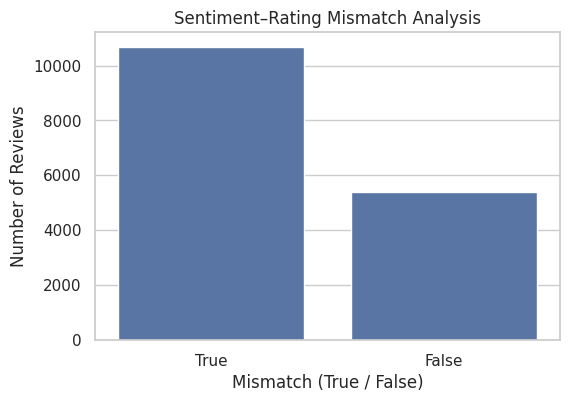

In [ ]:
mismatch_counts = df["sentiment_mismatch"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=mismatch_counts.index.astype(str),
    y=mismatch_counts.values
)

plt.title("Sentiment–Rating Mismatch Analysis")
plt.xlabel("Mismatch (True / False)")
plt.ylabel("Number of Reviews")
plt.show()


In [ ]:
total = len(df)
mismatch_pct = (df["sentiment_mismatch"].sum() / total) * 100

print(f"Total reviews: {total}")
print(f"Sentiment–Rating mismatch: {mismatch_pct:.2f}%")


Total reviews: 16074
Sentiment–Rating mismatch: 66.42%


In [ ]:
inflated_reviews = df[
    (df["Rating"] >= 4) &
    (df["predicted_sentiment"] == "Negative")
]

print("High-rating but negative-text reviews:", len(inflated_reviews))


High-rating but negative-text reviews: 4210


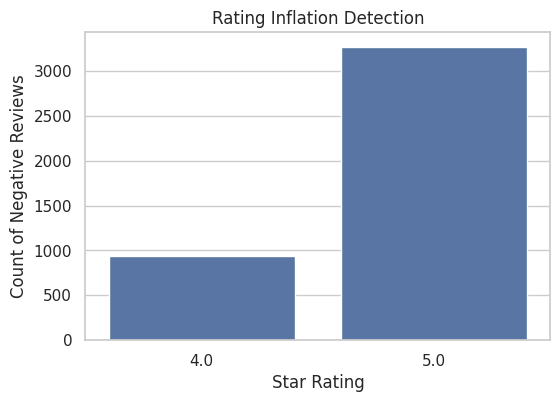

In [ ]:
inflation_counts = inflated_reviews["Rating"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=inflation_counts.index,
    y=inflation_counts.values
)

plt.title("Rating Inflation Detection")
plt.xlabel("Star Rating")
plt.ylabel("Count of Negative Reviews")
plt.show()


In [ ]:
inflated_reviews[
    ["Reviews", "Rating", "predicted_sentiment"]
].head(5)


,Reviews,Rating,predicted_sentiment
3,It works good but it goes slow sometimes but i...,4.0,Negative
4,Great phone to replace my lost phone. The only...,4.0,Negative
16,I was able to get the phone I previously owned...,5.0,Negative
17,I brought this phone as a replacement for my d...,5.0,Negative
20,The battery was old & had been over used becau...,4.0,Negative


In [ ]:
df.columns

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes', 'cleaned_review', 'predicted_sentiment',
       'rating_sentiment', 'sentiment_mismatch'],
      dtype='object')

In [ ]:
total_brands = df["Brand Name"].nunique()
print("Total number of unique brands:", total_brands)

Total number of unique brands: 34


In [ ]:
brand_product_counts = (
    df.groupby(["Brand Name", "Product Name"])
      .size()
      .reset_index(name="Review_Count")
)

brand_product_counts.head()


,Brand Name,Product Name,Review_Count
0,AKUA,"AKUA AKUMOBEK40W01 4.0"" EK4 Smartphone - GSM U...",2
1,Acer,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,2
2,Acer,Acer Liquid M220 Windows 8.1 Smartphone - Black,14
3,Acer,Acer Liquid Z410 Andoid KitKat Unlocked Quad-C...,1
4,Acer,Acer Unlocked Dual Sim Smart Phone Liquid Z200,1


In [ ]:
brand_product_counts["Product_Index"] = (
    brand_product_counts
    .groupby("Brand Name")["Review_Count"]
    .rank(method="first", ascending=False)
    .astype(int)
)

In [ ]:
brand_product_pivot = brand_product_counts.pivot_table(
    index="Brand Name",
    columns="Product_Index",
    values="Review_Count",
    fill_value=0
)


In [ ]:
unique_product_count = (
    df.groupby("Brand Name")["Product Name"]
      .nunique()
)

brand_product_pivot.insert(
    0,
    "Unique Product Count",
    unique_product_count
)


In [ ]:
brand_product_pivot.columns = [
    "Unique Product Count"
    if col == "Unique Product Count"
    else f"Product {col}"
    for col in brand_product_pivot.columns
]

brand_product_pivot.head()


,Unique Product Count,Product 1,Product 2,Product 3,Product 4,Product 5,Product 6,Product 7,Product 8,Product 9,...,Product 73,Product 74,Product 75,Product 76,Product 77,Product 78,Product 79,Product 80,Product 81,Product 82
Brand Name,,,,,,,,,,,,,,,,,,,,,
AKUA,1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acer,4,14.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aeku,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alcatel,13,761.0,203.0,60.0,35.0,24.0,16.0,15.0,13.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amazon,1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
product_columns = [col for col in brand_product_pivot.columns if col.startswith("Product ")]

brand_product_pivot["Sum_of_Product_Reviews"] = (
    brand_product_pivot[product_columns].sum(axis=1)
)


In [ ]:
brand_total_reviews = df.groupby("Brand Name").size()

validation = brand_product_pivot["Sum_of_Product_Reviews"] == brand_total_reviews
print("All brands validated:", validation.all())


All brands validated: True


In [ ]:
brand_product_pivot.reset_index().to_csv(
    "brand_product_wise_review_breakdown.csv",
    index=False
)


In [ ]:
total_reviews = len(df)

mapped_reviews = df.groupby(["Brand Name", "Product Name"]).size().sum()

print("Total unique reviews:", total_reviews)
print("Brand–product mapped reviews:", mapped_reviews)
print("Unmapped reviews:", total_reviews - mapped_reviews)


Total unique reviews: 16074
Brand–product mapped reviews: 12481
Unmapped reviews: 3593


In [ ]:
df_check = df.copy()

df_check["review_key"] = (
    df_check["Brand Name"].astype(str) + "||" +
    df_check["Product Name"].astype(str) + "||" +
    df_check["Reviews"].astype(str)
)


In [ ]:
brand_product_df = (
    df.groupby(["Brand Name", "Product Name"])
      .size()
      .reset_index()
)

mapped_reviews = df.merge(
    brand_product_df[["Brand Name", "Product Name"]],
    on=["Brand Name", "Product Name"],
    how="inner"
)


In [ ]:
unmapped_reviews = df_check[
    ~df_check["review_key"].isin(mapped_reviews.assign(
        review_key = (
            mapped_reviews["Brand Name"].astype(str) + "||" +
            mapped_reviews["Product Name"].astype(str) + "||" +
            mapped_reviews["Reviews"].astype(str)
        )
    )["review_key"])
]


In [ ]:
print("Number of unmapped reviews:", len(unmapped_reviews))
unmapped_reviews.head(10)


Number of unmapped reviews: 3593


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,cleaned_review,predicted_sentiment,rating_sentiment,sentiment_mismatch,review_key
104,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,2.0,when i got phone it wouldn't work I took it to...,0.0,when i got phone it wouldnt work i took it to ...,Negative,Negative,False,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
105,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,4.0,I liked,0.0,i liked,Positive,Positive,False,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
106,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,5.0,Great. Arrived quickly.,0.0,great arrived quickly,Positive,Positive,False,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
107,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,4.0,"Phone works great, you may have to get a sum c...",0.0,phone works great you may have to get a sum ca...,Negative,Positive,True,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
108,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,5.0,Avianna LLC is an incredible seller. The phone...,0.0,avianna llc is an incredible seller the phone ...,Negative,Positive,True,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
109,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,3.0,"Ad advertised as unlocked, had to pay $30..00 ...",0.0,ad advertised as unlocked had to pay to have u...,Neutral,Neutral,False,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
110,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,5.0,Exactly what I was expecting.thank you.,1.0,exactly what i was expectingthank you,Positive,Positive,False,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
111,((Unlocked))BlackBerry Bold 9650 Unlocked Clea...,NaN,269.10,5.0,Got it faster than I expected. Just what I nee...,0.0,got it faster than i expected just what i need...,Negative,Positive,True,nan||((Unlocked))BlackBerry Bold 9650 Unlocked...
253,"2.45 "" IPS Touch Screen the World's Smallest A...",NaN,72.99,1.0,My friend brought it to me at work after i ord...,3.0,my friend brought it to me at work after i ord...,Neutral,Negative,True,"nan||2.45 "" IPS Touch Screen the World's Small..."
293,"4 Inch Touch Screen Cell Phone Unlocked, Andro...",NaN,23.90,3.0,The phone is REALLY slow. It doesn't have enou...,1.0,the phone is really slow it doesnt have enough...,Negative,Neutral,True,"nan||4 Inch Touch Screen Cell Phone Unlocked, ..."


In [ ]:
brand_product_samples = (
    df.groupby(["Brand Name", "Product Name"])
      .size()
      .reset_index(name="Number of Reviews")
)
brand_product_samples.head(10)

,Brand Name,Product Name,Number of Reviews
0,AKUA,"AKUA AKUMOBEK40W01 4.0"" EK4 Smartphone - GSM U...",2
1,Acer,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,2
2,Acer,Acer Liquid M220 Windows 8.1 Smartphone - Black,14
3,Acer,Acer Liquid Z410 Andoid KitKat Unlocked Quad-C...,1
4,Acer,Acer Unlocked Dual Sim Smart Phone Liquid Z200,1
5,Aeku,"Aeku M5, 1.0 Inch 4.5mm Ultra Thin Fashionable...",1
6,Alcatel,ALCATEL Factory Unlocking Codes. This unlockin...,2
7,Alcatel,ALCATEL OneTouch Idol 3 Global Unlocked 4G LTE...,203
8,Alcatel,ALCATEL OneTouch Idol 3 Global Unlocked 4G LTE...,761
9,Alcatel,ALCATEL OneTouch Pixi 3 Global Unlocked 3G Sma...,24


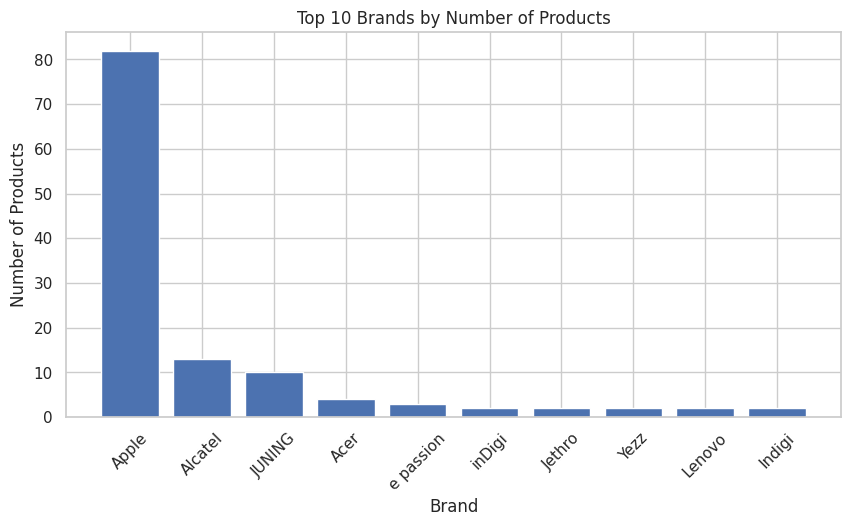

In [ ]:
import matplotlib.pyplot as plt

top_brands = brand_product_counts.sort_values(
    by="Unique Products Count",
    ascending=False
).head(10)

plt.figure(figsize=(10,5))
plt.bar(top_brands["Brand Name"], top_brands["Unique Products Count"])
plt.xticks(rotation=45)
plt.title("Top 10 Brands by Number of Products")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.show()


###Product-wise sentiment distribution

In [ ]:
product_wise_sentiment = (
    df.groupby(["Brand Name", "Product Name", "predicted_sentiment"])
      .size()
      .reset_index(name="Count")
)

product_wise_sentiment.to_csv(
    "product_wise_sentiment_analysis.csv",
    index=False
)

product_wise_sentiment.head()


,Brand Name,Product Name,predicted_sentiment,Count
0,AKUA,"AKUA AKUMOBEK40W01 4.0"" EK4 Smartphone - GSM U...",Negative,2
1,Acer,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,Negative,1
2,Acer,Acer Liquid Jade Z Andoid KitKat Unlocked Quad...,Neutral,1
3,Acer,Acer Liquid M220 Windows 8.1 Smartphone - Black,Negative,5
4,Acer,Acer Liquid M220 Windows 8.1 Smartphone - Black,Neutral,8


###Brand-wise overall sentiment

In [ ]:
brand_sentiment = (
    df.groupby(["Brand Name", "predicted_sentiment"])
      .size()
      .reset_index(name="Count")
)

brand_sentiment.head()


,Brand Name,predicted_sentiment,Count
0,AKUA,Negative,2
1,Acer,Negative,6
2,Acer,Neutral,11
3,Acer,Positive,1
4,Aeku,Negative,1
